# Building out CAE-M
Research paper link


In [2]:
# pip install tensorflow

In [28]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
import keras
from keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
# from autoencoder_model_dish_5g import Autoencoder_Model_Dish_5g
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from keras.losses import mse
from sklearn.model_selection import train_test_split

import _pickle as cPickle


------

In [4]:
##global variable
# H = 6
# t = 10
# T = 60
# M = 6



h = 4
timePerTemporalSlice = 12


timesteps = h * timePerTemporalSlice
time_steps = h * timePerTemporalSlice
batch_size = 6
n_samples = batch_size*100
features = ['node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

## Imports

In [5]:
pd.set_option('display.max_rows', None)

First lets read in our training sample set 

In [6]:
training_df_full = pd.read_parquet('/root/healthy_clusters_node_month.parquet')

In [7]:
training_df_full.head()

,Timestamp,InstanceId,ClusterName,node_cpu_utilization,node_cpu_limit,node_cpu_request,node_cpu_usage_total,node_memory_utilization,node_memory_request,node_memory_limit,node_network_rx_bytes,node_network_rx_dropped,node_network_rx_errors,node_network_rx_packets,node_network_total_bytes,node_network_tx_bytes,node_network_tx_dropped,node_network_tx_errors,node_network_tx_packets
0,1654235914008,i-01470d8d8e7b4fd2f,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,2.905276,4000.0,1266.0,116.211031,9.394841,998244352,16476487680,26133.384568,0.0,0.0,87.334264,56498.252063,30364.867495,0.0,0.0,86.300537
1,1654235917104,i-0b36e8825c482f762,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,1.836838,4000.0,1066.0,73.473529,7.296163,851443712,16476487680,5812.096097,0.0,0.0,22.781011,13940.610609,8128.514512,0.0,0.0,22.814785
2,1654232669947,i-01470d8d8e7b4fd2f,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,2.950336,4000.0,1266.0,118.013421,9.399117,998244352,16476487680,24538.169434,0.0,0.0,86.939803,54629.097665,30090.928231,0.0,0.0,86.904324
3,1654232681444,i-0b36e8825c482f762,nk-ndc-eks-cluster-dev-usw2-az1-dev-ncm01,1.858162,4000.0,1066.0,74.326468,7.295069,851443712,16476487680,5451.981961,0.0,0.0,21.206624,13392.905270,7940.923309,0.0,0.0,21.632175
4,1654235970093,i-093473861e74eaf2d,mt-ndc-eks-cluster-dev-mt-use1,0.942944,16000.0,1266.0,150.871041,4.956222,998244352,65902239744,42229.503040,0.0,0.0,251.934982,90291.404482,48061.901442,0.0,0.0,251.558398


In [8]:
columns_to_keep = ['Timestamp','InstanceId','node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

In [9]:
training_df = training_df_full.drop(training_df_full.columns.difference(columns_to_keep),1, inplace=False)
training_df['Timestamp'] = pd.to_datetime(training_df['Timestamp'], unit='ms')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [10]:
len(training_df)

2636965

In [11]:
training_df = training_df.dropna()

In [12]:
test_df = training_df.copy()
training_df = training_df[training_df.InstanceId != 'i-0b36e8825c482f762']

-----

# TRAIN DATASET: Build out Dataset for training on many nodes

now we are starting to build out a training dataset for two nodes. This will prove our understanding of how to model can generalize across many EC2 instances. 

In [13]:
## for normalization
# scaler = StandardScaler()

scaler = MinMaxScaler(feature_range=(0, 1))

In [14]:
instance_dfs =[]
for instance in training_df['InstanceId'].unique():
    if(len(training_df[training_df.InstanceId == instance]) >60):
        instance_dfs.append(training_df[training_df.InstanceId == instance].sort_values(by='Timestamp')\
                            .reset_index(drop=True))

In [15]:


import random 

x_train = np.zeros((n_samples,time_steps,len(features)))
for b in range(n_samples):
    
    ##pick random df, and normalize
    df = random.choice(instance_dfs)
    df = df.drop(columns = ['InstanceId'])
    df = df.set_index('Timestamp')
    df = df.sort_index()
    df[features] = scaler.fit_transform(df[features])
    
    
    
    sample = np.zeros((n_samples,len(features)))
    ##make sure length of df is atleast 40
#     print(len(df))
    first_time = random.choice(range(len(df)-time_steps))
    df.head()
    sample = df[features].iloc[first_time:first_time+time_steps]
    x_train[b] = sample

x_train.shape

(600, 48, 3)

our xtrain shape has the following properties: (sample size, time steps, numFeatures)

-------

# TEST DATASET: Build out Dataset for testing on one node

In [16]:
test_df = test_df[test_df.InstanceId == 'i-0b36e8825c482f762']

In [17]:
test_df.head()

,Timestamp,InstanceId,node_cpu_utilization,node_memory_utilization,node_network_total_bytes
1,2022-06-03 05:58:37.104,i-0b36e8825c482f762,1.836838,7.296163,13940.610609
3,2022-06-03 05:04:41.444,i-0b36e8825c482f762,1.858162,7.295069,13392.905270
9,2022-06-03 05:59:35.385,i-0b36e8825c482f762,1.824157,7.296387,14073.509120
11,2022-06-03 05:05:34.448,i-0b36e8825c482f762,1.821361,7.297928,14987.560707
17,2022-06-03 06:00:39.866,i-0b36e8825c482f762,1.811754,7.299718,13253.130119


In [18]:
## drop the instanceId
test_df = test_df.drop("InstanceId",1, inplace=False)


##set timestamp as the index
test_df = test_df.set_index('Timestamp')

##normalize test_df 
test_df[features] = scaler.fit_transform(test_df[features])


##ensure the data is sorted!!
test_df = test_df.sort_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


----

# CAE-M Time

In [19]:
H = 4
t = 12
T = H * t
M = 6
F = 3

----

##global variable

h = 2

timePerTemporalSlice = 6


timesteps = h * timePerTemporalSlice 

time_steps = h * timePerTemporalSlice

batch_size = 6

n_samples = batch_size*100

features = ['node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

In [20]:
xtrain = x_train.reshape(n_samples,F,T)
xtrain.shape

(600, 3, 48)

### First we build input_reshaper

In [21]:
sample_F_N = keras.Input(shape=(F,T), name="sample_F_N")

sample_H_F_T = layers.Reshape((H,F,t), input_shape=(F,T)) (sample_F_N)

input_reshaper = keras.Model(sample_F_N, sample_H_F_T, name="input_reshaper")
input_reshaper.summary()

Model: "input_reshaper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sample_F_N (InputLayer)     [(None, 3, 48)]           0         
                                                                 
 reshape (Reshape)           (None, 4, 3, 12)          0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


### Next we build encoder

In [22]:
encoder_input = keras.Input(shape=(F,t,1), name="encoder_input_F_T_Channels_h1")
x = layers.Conv2D(32, 2, activation="relu", padding = 'same')(encoder_input)
x = layers.MaxPooling2D((2,2), strides = 1, padding = 'same')(x)
x = layers.Conv2D(64, 2, activation="relu", padding = 'same')(x)
encoder_output = layers.MaxPooling2D((2,2), strides = 1, padding = 'same')(x)
encoder = keras.Model(encoder_input, encoder_output , name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input_F_T_Channels_  [(None, 3, 12, 1)]       0         
 h1 (InputLayer)                                                 
                                                                 
 conv2d (Conv2D)             (None, 3, 12, 32)         160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 12, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 12, 64)         8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 12, 64)        0         
 2D)                                                             
                                                           

### Next we build decoder

In [23]:
decoder_input = keras.Input(shape=(F, t, 64), name="ecoded")
x = layers.Conv2DTranspose(64, 2, activation="relu",padding = 'same')(decoder_input)
x = layers.Conv2DTranspose(32, 2, activation="relu",padding = 'same')(x)
decoded_slice = layers.Conv2DTranspose(1, 2, activation="relu",padding = 'same')(x)
decoded_slice = layers.Reshape((F,t), input_shape=(F,t,1)) (decoded_slice)
decoder = keras.Model(decoder_input, decoded_slice, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecoded (InputLayer)         [(None, 3, 12, 64)]       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 3, 12, 64)        16448     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 3, 12, 32)        8224      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 3, 12, 1)         129       
 ranspose)                                                       
                                                                 
 reshape_1 (Reshape)         (None, 3, 12)             0         
                                                           

### Next we build BILSTM

In [29]:
BiLSTM_input = keras.Input(shape=(H-1,F*t*65), name="BiLSTM_input")

x = layers.Bidirectional(layers.LSTM(512,return_sequences=True))(BiLSTM_input)
x = SeqWeightedAttention(H-1)(x)
BiLSTM_output = layers.Dense(F*t*65)(x)

BiLSTM = keras.Model(BiLSTM_input, BiLSTM_output, name="BiLSTM")
BiLSTM.summary()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BiLSTM_input (InputLayer)   [(None, 3, 2340)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 1024)          11685888  
 nal)                                                            
                                                                 
 seq_weighted_attention_1 (S  (None, 1024)             1025      
 eqWeightedAttention)                                            
                                                                 
 dense_2 (Dense)             (None, 2340)              2398500   
                                                                 
Total params: 14,085,413
Trainable params: 14,085,413
Non-trainable params: 0
_________________________________________________________________


### Next we build Linear Predictor

In [27]:
linear_input = keras.Input(shape=((H-1)*F*t*65), name="linear_input")
linear_output = layers.Dense(F*t*65)(linear_input)
linear_predictor = keras.Model(linear_input, linear_output, name="linear_predictor")
linear_predictor.summary()

Model: "linear_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear_input (InputLayer)   [(None, 7020)]            0         
                                                                 
 dense_1 (Dense)             (None, 2340)              16429140  
                                                                 
Total params: 16,429,140
Trainable params: 16,429,140
Non-trainable params: 0
_________________________________________________________________


### Now we assemble CAE-M

In [ ]:
# H = 4
# t = 12
# T = H * t
# M = 6
# F = 3
""" INPUT TIME """
##input for CAE-M, with shape (F,T). This input gets reshaped into (H,F,t)
wrongshape_input = keras.Input(shape=(F,T), name="sample")
reshaped_input = input_reshaper(wrongshape_input)

""" AUTOENCODER TIME """
##LATENT SPACE Zf
encoded_temporal_slices = [encoder(reshaped_input[:,temporal_slice,:,:]) for temporal_slice in range(H)]
##OUTPUT OF AUTOENCODER
decoded_temporal_slices = [decoder(encoded_temporal_slices[temporal_slice]) for temporal_slice in range(H)]
decoded_for_output = layers.Concatenate(name = 'decoded_for_output')(decoded_temporal_slices)


##CREATE Z = Zf + Zr
## Zr is residual of the autoencoder
residuals  = [reshaped_input[:,temporal_slices,:,:] - decoded_temporal_slices[temporal_slices] for temporal_slices in range(H) ]
# residuals = tf.convert_to_tensor(residuals)
residuals = [layers.Reshape((3,12,1))(residuals[temporal_slices])  for temporal_slices in range(H)]
Z = [layers.Concatenate()([encoded_temporal_slices[temporal_slices],residuals[temporal_slices]]) for temporal_slices in range(H) ] 
Z_flattened = [ layers.Flatten()(Z[temporal_slices]) for temporal_slices in range(H)]


##CREATE THE LABEL for CAE-M forecasters
Y = Z_flattened[-1]



""" BILSTM TIME """
##RESHAPE FOR INPUT FOR LSTM -->> NEED shape [BATCHSIZE, H-1, F*t*65] and then predict to the BiLSTM
Z_flattened = Z_flattened[:-1]
Z_flattened = [ layers.Reshape((1,2340))(Z_flattened[temporal_slices]) for temporal_slices in range(H-1)]

Z_flattened = layers.Concatenate(name = 'z_flatten_concat', axis =1)(Z_flattened)
## Feed BILSTM
Y_hat = BiLSTM(Z_flattened)


""" LINEAR TIME """
##RESHAPE input again for the linear predictor --> NEED shape [Batchsize, (H-1)*F*t*65] and then feed to linear predictor
Z_flattened_stack = layers.Flatten(name = 'Z_flattened_for_linear')(Z_flattened)
Z_hat = linear_predictor(Z_flattened_stack)

""" CAE-M TIME """
CAEM = keras.Model(inputs = wrongshape_input,  outputs = [wrongshape_input,decoded_for_output,Y,Y_hat,Z_hat],
                          name="CAE-M")

""" Loss TIME """

loss = mse(wrongshape_input, decoded_for_output) + (.5 *mse(Y_hat, Y)) + (.5 *mse(Z_hat, Y))
CAEM.add_loss(loss)





In [ ]:
CAEM.summary()

In [41]:
CAEM.compile(optimizer='sgd')

In [57]:
history = CAEM.fit(
                xtrain,
                epochs=100,
                validation_split=.1,
                batch_size=3)
            


Epoch 1/100
200/200 [==============================] - 13s 64ms/step - loss: 0.0048
Epoch 2/100
200/200 [==============================] - 13s 65ms/step - loss: 0.0044
Epoch 3/100
200/200 [==============================] - 13s 64ms/step - loss: 0.0042
Epoch 4/100
200/200 [==============================] - 13s 64ms/step - loss: 0.0040
Epoch 5/100
200/200 [==============================] - 13s 64ms/step - loss: 0.0039
Epoch 6/100
200/200 [==============================] - 13s 65ms/step - loss: 0.0037
Epoch 7/100
200/200 [==============================] - 13s 64ms/step - loss: 0.0036
Epoch 8/100
200/200 [==============================] - 13s 64ms/step - loss: 0.0035
Epoch 9/100
200/200 [==============================] - 13s 66ms/step - loss: 0.0034
Epoch 10/100
200/200 [==============================] - 13s 64ms/step - loss: 0.0034
Epoch 11/100
200/200 [==============================] - 13s 65ms/step - loss: 0.0033
Epoch 12/100
200/200 [==============================] - 13s 64ms/step - lo

KeyError: 'val_loss'

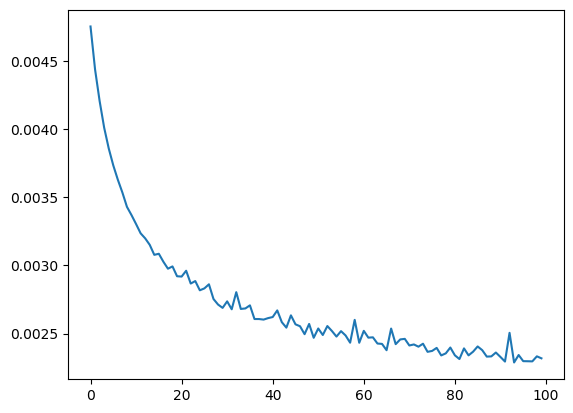

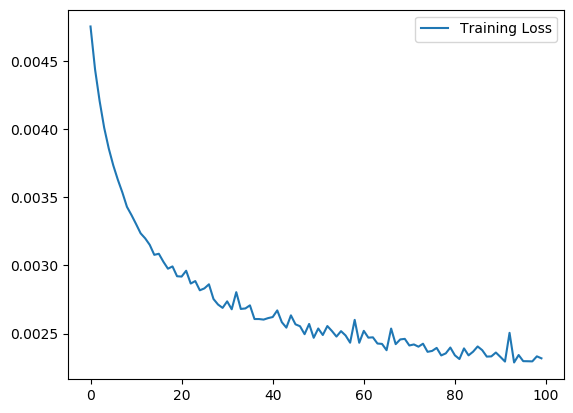

In [58]:
##plot the train loss and val loss
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()